# Contexto y formulación del problema


Problema (aprendizaje supervisado)

Dado un conjunto de imágenes de hojas de tomate etiquetadas por clase (enfermedad/estado), entrenar un modelo que prediga la clase de una imagen nueva.

* **Tipo de tarea:** Clasificación multiclase (10 clases).
* **Variable objetivo (y):** etiqueta de clase = nombre de la subcarpeta (p. ej., Tomato___Late_blight).
* **Variables de entrada (X):** píxeles de la imagen (tras preprocesamiento) + transformaciones (augmentations).

**Tomadores de decisión (beneficiarios)**

* Productores agrícolas / técnicos de campo: apoyo a diagnóstico temprano.

* Encargados de fitosanidad: priorización de tratamientos, monitoreo y control.

* Investigadores/agronomía: cuantificación de incidencia por zona/temporada.

**Por qué es desafiante computacionalmente**

Variabilidad por iluminación, ángulo, fondo, escala, daño parcial.

* Patrones visuales sutiles y no lineales entre enfermedades.

* Posible desbalance de clases y “intra-clase” alta (misma enfermedad con apariencias distintas).

* Enfoques tradicionales (reglas explícitas) son frágiles ante ruido/variabilidad.

Esto calza con “Contexto y formulación” del documento.

In [1]:
# ============================================
# 1
# Descargar SOLO una carpeta desde GitHub en Google Colab (Sparse Checkout)
# Deja la carpeta lista en /content/DataImg
# ============================================

import os
import shutil
import subprocess

# 1) Variables
REPO_URL = "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"
FOLDER_NAME = "DataImg/TomatoDataset_ready"
TMP_DIR = "/content/repo_temporal"

# 2) Helpers
def run(cmd, cwd=None):
    print(f"\n$ {cmd}")
    subprocess.check_call(cmd, shell=True, cwd=cwd)

def get_default_branch(repo_url):
    # Detecta rama por defecto (main / master)
    try:
        out = subprocess.check_output(
            f'git ls-remote --symref {repo_url} HEAD',
            shell=True,
            text=True
        )
        for line in out.splitlines():
            if line.startswith("ref:"):
                return line.split("refs/heads/")[-1].split("\t")[0].strip()
    except Exception:
        pass
    return "main"

# 3) Preparación: limpiar previos
shutil.rmtree(TMP_DIR, ignore_errors=True)
shutil.rmtree(f"/content/{FOLDER_NAME}", ignore_errors=True)
os.makedirs(TMP_DIR, exist_ok=True)

# 4) Detectar rama por defecto
BRANCH = get_default_branch(REPO_URL)
print(f" Rama detectada: {BRANCH}")

# 5) Inicializar repo temporal y configurar sparse checkout
run("git init", cwd=TMP_DIR)
run(f'git remote add origin "{REPO_URL}"', cwd=TMP_DIR)
run("git sparse-checkout init --cone", cwd=TMP_DIR)
run(f'git sparse-checkout set "{FOLDER_NAME}"', cwd=TMP_DIR)

# 6) Descargar solo esa carpeta
run(f'git pull --depth 1 origin "{BRANCH}"', cwd=TMP_DIR)

# 7) Mover a /content y limpiar
src_path = os.path.join(TMP_DIR, FOLDER_NAME)
dst_path = os.path.join("/content", FOLDER_NAME)

if not os.path.exists(src_path):
    raise FileNotFoundError(
        f"No se encontró la carpeta '{FOLDER_NAME}' en el repo. "
        f"Revisa que exista en la rama '{BRANCH}'."
    )

shutil.move(src_path, dst_path)
shutil.rmtree(TMP_DIR, ignore_errors=True)

print(f"\n Proceso finalizado. Carpeta lista en: {dst_path}")
print(" Archivos (primeros 30):")
print(os.listdir(dst_path)[:30])


 Rama detectada: main

$ git init

$ git remote add origin "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"

$ git sparse-checkout init --cone

$ git sparse-checkout set "DataImg/TomatoDataset_ready"

$ git pull --depth 1 origin "main"

 Proceso finalizado. Carpeta lista en: /content/DataImg/TomatoDataset_ready
 Archivos (primeros 30):
['Tomato___Target_Spot', 'Tomato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Leaf_Mold', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite']


 Bloque 2 — Validación de estructura para YOLO (Clasificación)

Este validador asume el formato de tu imagen:
/content/DataImg/TomatoDataset_ready/<CLASE>/*.jpg
Eso corresponde a YOLOv8 en modo clasificación (yolo classify), no a detección/segmentación.

In [2]:
# ============================================
# 2
# Validación de estructura del dataset para YOLO (modo clasificación - YOLOv8-cls)
# Espera: /content/DataImg/TomatoDataset_ready/<clase>/*.jpg|png|jpeg
# ============================================

import os
from pathlib import Path
from collections import Counter

DATASET_DIR = Path("/content/DataImg/TomatoDataset_ready")
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def is_image(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in IMG_EXTS

# 1) Validar existencia
print(f" Dataset path: {DATASET_DIR}")
if not DATASET_DIR.exists():
    raise FileNotFoundError(f"❌ No existe: {DATASET_DIR}. Revisa el bloque 1.")

# 2) Detectar si es clasificación (carpetas = clases) o si ya tiene train/val
entries = [p for p in DATASET_DIR.iterdir() if p.is_dir()]
has_train_val = (DATASET_DIR / "train").exists() and (DATASET_DIR / "val").exists()

print("\n Tipo de estructura detectada:")
if has_train_val:
    print(" Estructura con train/val detectada (ideal para YOLO clasificación).")
else:
    print("ℹ Estructura 'carpetas por clase' detectada (como en tu imagen).")
    print("    Para YOLOv8-cls normalmente se recomienda /train y /val.")
    print("    Aun así, tu estructura es válida como dataset base; luego puedes splittear.")

# 3) Si hay train/val, validar dentro de cada split
def scan_class_folders(root: Path):
    class_dirs = [d for d in root.iterdir() if d.is_dir()]
    if not class_dirs:
        return [], {}, {}

    counts = {}
    bad_files = []
    for cdir in class_dirs:
        imgs = [p for p in cdir.rglob("*") if is_image(p)]
        counts[cdir.name] = len(imgs)

        # archivos no imagen dentro de clases
        for p in cdir.rglob("*"):
            if p.is_file() and (p.suffix.lower() not in IMG_EXTS):
                bad_files.append(p)

    return class_dirs, counts, bad_files

if has_train_val:
    for split in ["train", "val"]:
        split_dir = DATASET_DIR / split
        print(f"\n Analizando split: {split_dir}")
        class_dirs, counts, bad_files = scan_class_folders(split_dir)

        if not class_dirs:
            print(" No se encontraron carpetas de clase dentro de este split.")
            continue

        print(f" Clases encontradas ({len(class_dirs)}): {sorted([d.name for d in class_dirs])}")
        print(" Imágenes por clase (top 10):")
        for k, v in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]:
            print(f"  - {k}: {v}")

        if any(v == 0 for v in counts.values()):
            empties = [k for k, v in counts.items() if v == 0]
            print(f" Clases vacías: {empties}")

        if bad_files:
            print(f" Archivos no-imagen detectados (muestra 10):")
            for p in bad_files[:10]:
                print("  -", p)
else:
    # Estructura por clases (como la imagen)
    class_dirs, counts, bad_files = scan_class_folders(DATASET_DIR)

    if not class_dirs:
        raise RuntimeError(" No se encontraron carpetas de clase en el dataset.")

    print(f"\n Clases encontradas ({len(class_dirs)}): {sorted([d.name for d in class_dirs])}")
    total_imgs = sum(counts.values())
    print(f" Total imágenes: {total_imgs}")

    # Distribución
    print("\n Imágenes por clase (orden descendente):")
    for k, v in sorted(counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {k}: {v}")

    # Alertas típicas
    if len(class_dirs) < 2:
        print("\n Solo se detectó 1 clase. Para clasificación se requieren 2+ clases.")
    if any(v == 0 for v in counts.values()):
        empties = [k for k, v in counts.items() if v == 0]
        print(f"\n Clases vacías: {empties}")

    # Archivos raros
    if bad_files:
        print(f"\n Archivos no-imagen detectados (muestra 10):")
        for p in bad_files[:10]:
            print("  -", p)

    # Recomendación train/val
    print("\n Recomendación para YOLOv8-cls:")
    print("   - Ideal: /TomatoDataset_ready/train/<clase>/... y /val/<clase>/...")
    print("   - Si aún no tienes split, en el siguiente bloque podemos crearlo automáticamente (80/20).")


 Dataset path: /content/DataImg/TomatoDataset_ready

 Tipo de estructura detectada:
ℹ Estructura 'carpetas por clase' detectada (como en tu imagen).
    Para YOLOv8-cls normalmente se recomienda /train y /val.
    Aun así, tu estructura es válida como dataset base; luego puedes splittear.

 Clases encontradas (10): ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
 Total imágenes: 17543

 Imágenes por clase (orden descendente):
  - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4761
  - Tomato___Bacterial_spot: 2126
  - Tomato___Late_blight: 1897
  - Tomato___Septoria_leaf_spot: 1771
  - Tomato___Spider_mites Two-spotted_spider_mite: 1676
  - Tomato___healthy: 1585
  - Tomato___Target_Spot: 1404
  - Tomato___Early_blight: 998
  - Tomato___Leaf_Mold: 

## Crear una estructura compatible con YOLO (clasificación) copiando los archivos originales

**Qué haremos:** crearemos un nuevo directorio con la estructura esperada por **YOLOv8 en modo clasificación**:  
`/content/DataImg_yolo_cls/{train,val}/{clase}/imagen.jpg`

Luego copiaremos (sin modificar los originales) las imágenes desde:  
`/content/DataImg/TomatoDataset_ready/<clase>/*`  
hacia la nueva estructura, realizando un split **estratificado por clase** (por defecto 80/20).

**Por qué:** Ultralytics YOLO para clasificación funciona mejor y de forma estándar cuando existe una separación explícita en `train/val`, manteniendo subcarpetas por clase. Esto facilita entrenamiento, validación, reproducibilidad y despliegue.

**Resultado esperado:** un nuevo dataset listo para entrenar con:
`yolo classify train data=/content/DataImg_yolo_cls model=yolov8n-cls.pt`
y un resumen de conteos por clase en train/val.


In [3]:
# ============================================
# 3) Crear estructura YOLOv8-cls (train/val) copiando archivos originales
# Fuente: /content/DataImg/TomatoDataset_ready/<clase>/*
# Destino: /content/DataImg_yolo_cls/{train,val}/{clase}/*
# ============================================

import os
import shutil
import random
from pathlib import Path
from collections import defaultdict

# Reproducibilidad
SEED = 42
random.seed(SEED)

# Paths
SRC_ROOT = Path("/content/DataImg/TomatoDataset_ready")
DST_ROOT = Path("/content/DataImg_yolo_cls")

TRAIN_DIR = DST_ROOT / "train"
VAL_DIR   = DST_ROOT / "val"

# Split
VAL_RATIO = 0.2  # 20% para validación (ajusta si quieres)

# Extensiones admitidas
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def is_image(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in IMG_EXTS

# 1) Validaciones básicas
if not SRC_ROOT.exists():
    raise FileNotFoundError(f" No existe el origen: {SRC_ROOT}. Ejecuta el bloque de descarga primero.")

class_dirs = [d for d in SRC_ROOT.iterdir() if d.is_dir()]
if len(class_dirs) < 2:
    raise RuntimeError(f" Se detectaron {len(class_dirs)} clases. Para clasificación se requieren 2+.")

# 2) Preparar destino (no borra origen)
if DST_ROOT.exists():
    shutil.rmtree(DST_ROOT)
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VAL_DIR.mkdir(parents=True, exist_ok=True)

print(f" Origen:  {SRC_ROOT}")
print(f" Destino: {DST_ROOT}")
print(f" Split: train={(1-VAL_RATIO):.0%} / val={VAL_RATIO:.0%} (SEED={SEED})")

# 3) Copiar con split por clase
counts = {
    "train": defaultdict(int),
    "val": defaultdict(int),
    "skipped_non_images": 0
}

for cdir in sorted(class_dirs, key=lambda x: x.name.lower()):
    cname = cdir.name

    images = [p for p in cdir.rglob("*") if is_image(p)]
    if len(images) == 0:
        print(f" Clase vacía (sin imágenes): {cname} -> se omite")
        continue

    random.shuffle(images)
    n_val = max(1, int(len(images) * VAL_RATIO)) if len(images) >= 5 else max(0, int(len(images) * VAL_RATIO))
    val_set = set(images[:n_val])
    train_set = images[n_val:]

    # Crear carpetas destino por clase
    (TRAIN_DIR / cname).mkdir(parents=True, exist_ok=True)
    (VAL_DIR / cname).mkdir(parents=True, exist_ok=True)

    # Copiar a train
    for img_path in train_set:
        dst_path = TRAIN_DIR / cname / img_path.name
        shutil.copy2(img_path, dst_path)
        counts["train"][cname] += 1

    # Copiar a val
    for img_path in val_set:
        dst_path = VAL_DIR / cname / img_path.name
        shutil.copy2(img_path, dst_path)
        counts["val"][cname] += 1

# 4) Reporte
print("\n====================")
print(" Resumen por clase")
print("====================")

all_classes = sorted(set(list(counts["train"].keys()) + list(counts["val"].keys())))
total_train = 0
total_val = 0

for cname in all_classes:
    tr = counts["train"][cname]
    va = counts["val"][cname]
    total_train += tr
    total_val += va
    print(f"- {cname:35s} | train: {tr:4d} | val: {va:4d}")

print("\n====================")
print(f" Total train: {total_train}")
print(f" Total val:   {total_val}")
print("====================")

# 5) Validación final de estructura
def check_structure(root: Path):
    ok = True
    for split in ["train", "val"]:
        split_dir = root / split
        if not split_dir.exists():
            print(f" Falta: {split_dir}")
            ok = False
            continue
        # Debe haber carpetas por clase
        class_folders = [d for d in split_dir.iterdir() if d.is_dir()]
        if not class_folders:
            print(f" No hay carpetas de clase en: {split_dir}")
            ok = False
        else:
            # Al menos 1 imagen por clase (idealmente)
            empty = []
            for d in class_folders:
                n_imgs = sum(1 for p in d.iterdir() if is_image(p))
                if n_imgs == 0:
                    empty.append(d.name)
            if empty:
                print(f" Clases vacías en {split}: {empty}")
    return ok

print("\n Chequeo final de estructura YOLOv8-cls:")
is_ok = check_structure(DST_ROOT)
print(" OK" if is_ok else " Revisa advertencias arriba")

print(f"\n Dataset listo para YOLOv8-cls en: {DST_ROOT}")
print("Ejemplo de entrenamiento:")
print("  !pip install ultralytics")
print(f"  !yolo classify train data={DST_ROOT} model=yolov8n-cls.pt imgsz=224 epochs=20")



 Origen:  /content/DataImg/TomatoDataset_ready
 Destino: /content/DataImg_yolo_cls
 Split: train=80% / val=20% (SEED=42)

 Resumen por clase
- Tomato___Bacterial_spot             | train: 1701 | val:  425
- Tomato___Early_blight               | train:  799 | val:  199
- Tomato___Late_blight                | train: 1518 | val:  379
- Tomato___Leaf_Mold                  | train:  762 | val:  190
- Tomato___Septoria_leaf_spot         | train: 1417 | val:  354
- Tomato___Spider_mites Two-spotted_spider_mite | train: 1341 | val:  335
- Tomato___Target_Spot                | train: 1124 | val:  280
- Tomato___Tomato_Yellow_Leaf_Curl_Virus | train: 3809 | val:  952
- Tomato___Tomato_mosaic_virus        | train:  299 | val:   74
- Tomato___healthy                    | train: 1268 | val:  317

 Total train: 14038
 Total val:   3505

 Chequeo final de estructura YOLOv8-cls:
 OK

 Dataset listo para YOLOv8-cls en: /content/DataImg_yolo_cls
Ejemplo de entrenamiento:
  !pip install ultralytics
  !yo

## Instalar Ultralytics y entrenar YOLOv8 en modo clasificación (YOLOv8-cls)

**Qué haremos:** instalaremos la librería `ultralytics`, verificaremos que el dataset generado tenga la estructura correcta (`train/` y `val/` con subcarpetas por clase), y entrenaremos un modelo **YOLOv8 de clasificación** (por defecto `yolov8n-cls.pt`) usando el directorio creado en el bloque anterior.

**Por qué:** Ultralytics proporciona un flujo estándar y robusto para clasificación con métricas, logs y exportación. Entrenar con `train/val` evita fuga de datos y permite validar generalización durante el entrenamiento.

**Resultado esperado:**
- Un experimento en `runs/classify/train...` con curvas de entrenamiento
- Métricas de validación por época
- Un modelo final (`best.pt`) listo para inferencia sobre nuevas imágenes


In [4]:
# ============================================
# 4) Entrenamiento YOLOv8 en modo clasificación
# Dataset: /content/DataImg_yolo_cls
# ============================================

import os
from pathlib import Path

DATA_DIR = Path("/content/DataImg_yolo_cls")
assert DATA_DIR.exists(), f" No existe {DATA_DIR}. Ejecuta el bloque de creación del dataset primero."

# 1) Instalar Ultralytics
!pip -q install ultralytics

# 2) Verificación rápida de estructura requerida por YOLOv8-cls
train_dir = DATA_DIR / "train"
val_dir   = DATA_DIR / "val"

assert train_dir.exists() and val_dir.exists(), "❌ Falta train/ o val/ en el dataset."

train_classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
val_classes   = sorted([d.name for d in val_dir.iterdir() if d.is_dir()])

print(" Clases en train:", train_classes)
print(" Clases en val:  ", val_classes)

assert train_classes == val_classes, " Las clases en train y val no coinciden."

# 3) Entrenar YOLOv8-cls
# Opciones recomendadas:
# - model: yolov8n-cls.pt (rápido), yolov8s-cls.pt (mejor), etc.
# - imgsz: 224/256 suele ir bien en clasificación
# - epochs: ajusta según tamaño del dataset
# - batch: si da OOM, bajar batch

MODEL = "yolov8n-cls.pt"
IMG_SIZE = 224
EPOCHS = 20
BATCH = 32

!yolo classify train data="{DATA_DIR}" model="{MODEL}" imgsz={IMG_SIZE} epochs={EPOCHS} batch={BATCH} seed=42

print("\n Entrenamiento finalizado. Revisa la carpeta runs/classify/ para resultados.")
!ls -lah runs/classify | tail -n 20


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.4 MB/s eta 0:00:00
 Clases en train: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
 Clases en val:   ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultr

## Evaluación del modelo entrenado e inferencia sobre imágenes (validación + predicción)

**Qué haremos:**  
1) Localizaremos el último experimento de entrenamiento dentro de `runs/classify/` y cargaremos el `best.pt`.  
2) Evaluaremos el modelo sobre el split de validación (`val/`) para obtener métricas agregadas.  
3) Ejecutaremos **inferencias** sobre algunas imágenes (del val o externas) y mostraremos ejemplos de predicción.

**Por qué:**  
- La evaluación formal valida la capacidad de generalización del modelo.  
- La inferencia con ejemplos permite inspeccionar errores típicos (confusiones entre clases, sesgos, imágenes difíciles).

**Resultado esperado:**  
- Métricas de validación del modelo (`top1`, `top5`, etc.)  
- Predicciones sobre imágenes de ejemplo (clase predicha + probabilidad)  
- Ruta del modelo `best.pt` lista para uso en producción/inferencia


In [5]:
# ============================================
# 5) Evaluación + Inferencia (YOLOv8-cls)
# ============================================

import os
from pathlib import Path
from ultralytics import YOLO
import random

DATA_DIR = Path("/content/DataImg_yolo_cls")
RUNS_DIR = Path("runs/classify")

assert DATA_DIR.exists(), f" No existe {DATA_DIR}. Ejecuta los bloques anteriores."
assert RUNS_DIR.exists(), " No existe runs/classify. Asegúrate de haber entrenado antes."

# 1) Encontrar el último experimento (más reciente) y el best.pt
exp_dirs = [d for d in RUNS_DIR.iterdir() if d.is_dir() and d.name.startswith("train")]
if not exp_dirs:
    raise RuntimeError(" No se encontraron experimentos en runs/classify (train*).")

latest_exp = max(exp_dirs, key=lambda p: p.stat().st_mtime)
best_path = latest_exp / "weights" / "best.pt"
last_path = latest_exp / "weights" / "last.pt"

print(f"📌 Experimento más reciente: {latest_exp}")
print(f"📌 best.pt: {best_path} -> {'OK' if best_path.exists() else 'NO ENCONTRADO'}")
print(f"📌 last.pt: {last_path} -> {'OK' if last_path.exists() else 'NO ENCONTRADO'}")

if not best_path.exists():
    raise FileNotFoundError(" No existe best.pt. Revisa si el entrenamiento terminó correctamente.")

# 2) Cargar modelo
model = YOLO(str(best_path))

# 3) Evaluación sobre val
# Nota: 'yolo classify val' también sirve, aquí lo hacemos vía API.
print("\n Evaluando en validación (val/)...")
metrics = model.val(data=str(DATA_DIR), imgsz=224)  # usa el mismo imgsz que entrenamiento si aplica

# Mostrar métricas principales (puede variar por versión)
print("\n Métricas disponibles en el objeto metrics:")
for k in dir(metrics):
    if "top" in k.lower() or "acc" in k.lower() or "fitness" in k.lower():
        try:
            v = getattr(metrics, k)
            if isinstance(v, (int, float)):
                print(f"- {k}: {v}")
        except:
            pass

# 4) Inferencia sobre algunas imágenes de val (muestra aleatoria)
VAL_DIR = DATA_DIR / "val"
assert VAL_DIR.exists(), " Falta carpeta val/."

# recolectar imágenes
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
val_imgs = [p for p in VAL_DIR.rglob("*") if p.is_file() and p.suffix.lower() in IMG_EXTS]
assert len(val_imgs) > 0, " No hay imágenes en val/."

sample_n = min(8, len(val_imgs))
sample_imgs = random.sample(val_imgs, sample_n)

print(f"\n Ejecutando inferencia sobre {sample_n} imágenes de val...")
results = model.predict([str(p) for p in sample_imgs], imgsz=224, verbose=False)

# 5) Mostrar predicciones (texto + render)
# Ultralytics suele permitir results[i].probs con top1/top5
for img_path, r in zip(sample_imgs, results):
    print("\n-------------------------------")
    print("Imagen:", img_path)
    if hasattr(r, "probs") and r.probs is not None:
        top1 = int(r.probs.top1)
        top1conf = float(r.probs.top1conf)
        name = r.names.get(top1, str(top1))
        print(f"Predicción TOP1: {name} (conf={top1conf:.3f})")

        # Top-5 (si existe)
        if hasattr(r.probs, "top5"):
            top5 = r.probs.top5
            print("Top-5:")
            for idx in top5:
                idx = int(idx)
                cname = r.names.get(idx, str(idx))
                conf = float(r.probs.data[idx])
                print(f"  - {cname}: {conf:.3f}")
    else:
        print(" No se encontraron probabilidades en el resultado. (posible cambio de API/versión)")

    # Render de la imagen con overlay (si aplica)
    try:
        im = r.plot()  # devuelve array (BGR)
        # Mostrar en Colab
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6, 6))
        plt.imshow(im[..., ::-1])  # BGR->RGB
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(" No se pudo renderizar la imagen:", e)

print(f"\n Listo. Modelo recomendado para producción: {best_path}")


Output hidden; open in https://colab.research.google.com to view.

## Exportación del modelo y preparación para despliegue (ONNX / TorchScript) + prueba rápida

**Qué haremos:**  
1) Exportaremos el modelo entrenado (`best.pt`) a formatos comunes de despliegue:  
- **ONNX** (compatibilidad amplia: TensorRT, OpenVINO, runtimes)  
- **TorchScript** (deploy PyTorch optimizado)  

2) Verificaremos que los archivos exportados existan y haremos una **predicción rápida** con el modelo exportado (si la versión de Ultralytics lo soporta directamente).

**Por qué:**  
- `best.pt` es perfecto para investigación y producción en PyTorch, pero para producción real suele convenir ONNX/TorchScript por rendimiento, portabilidad y aceleración por hardware.  

**Resultado esperado:**  
- Archivos exportados en `runs/classify/.../weights/` o en la ruta que indique Ultralytics  
- Confirmación de existencia y tamaños  
- (Opcional) Inferencia de sanity-check con el modelo exportado


In [6]:
# ============================================
# 6) Exportación del modelo (ONNX / TorchScript) + sanity check
# ============================================

from pathlib import Path
from ultralytics import YOLO
import os

# Localizar best.pt del último experimento (igual que en el bloque anterior)
RUNS_DIR = Path("runs/classify")
exp_dirs = [d for d in RUNS_DIR.iterdir() if d.is_dir() and d.name.startswith("train")]
latest_exp = max(exp_dirs, key=lambda p: p.stat().st_mtime)

best_pt = latest_exp / "weights" / "best.pt"
assert best_pt.exists(), f" No existe {best_pt}. Entrena primero."

print(f"📌 Experimento: {latest_exp}")
print(f"📌 Modelo: {best_pt}")

model = YOLO(str(best_pt))

# 1) Exportar a ONNX
print("\n Exportando a ONNX...")
onnx_path = model.export(format="onnx", opset=12, simplify=True)  # simplify puede requerir onnxsim, Ultralytics suele manejarlo
print(" ONNX exportado en:", onnx_path)

# 2) Exportar a TorchScript
print("\n Exportando a TorchScript...")
ts_path = model.export(format="torchscript")
print(" TorchScript exportado en:", ts_path)

# 3) Validar que existan y mostrar tamaños
def file_size_mb(p):
    p = Path(p)
    return p.stat().st_size / (1024**2)

print("\n Archivos exportados:")
for p in [onnx_path, ts_path]:
    p = Path(p)
    if p.exists():
        print(f" - {p} | {file_size_mb(p):.2f} MB")
    else:
        print(f" -  No encontrado: {p}")

# 4) (Opcional) Sanity-check de inferencia con ONNX (si Ultralytics lo soporta en tu versión)
# Nota: Algunas versiones permiten YOLO('model.onnx').predict(...)
try:
    print("\n Sanity-check: inferencia con ONNX sobre una imagen de val...")
    DATA_DIR = Path("/content/DataImg_yolo_cls")
    VAL_DIR = DATA_DIR / "val"
    IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    sample_img = next(p for p in VAL_DIR.rglob("*") if p.suffix.lower() in IMG_EXTS)

    onnx_model = YOLO(str(onnx_path))
    r = onnx_model.predict(str(sample_img), imgsz=224, verbose=False)[0]

    if hasattr(r, "probs") and r.probs is not None:
        top1 = int(r.probs.top1)
        conf = float(r.probs.top1conf)
        name = r.names.get(top1, str(top1))
        print(f" ONNX predicción TOP1: {name} (conf={conf:.3f})")
    else:
        print(" No se encontraron probs en el resultado ONNX (posible diferencia de backend).")

except Exception as e:
    print(" No se pudo hacer sanity-check con ONNX en esta configuración/version.")
    print("   Detalle:", str(e))

print("\n Exportación completada. Listo para despliegue en ONNX/TorchScript.")


📌 Experimento: runs/classify/train
📌 Modelo: runs/classify/train/weights/best.pt

 Exportando a ONNX...
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8n-cls summary (fused): 30 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs

PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 10) (2.8 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 176ms
Prepared 6 packages in 3.63s
Installed 6 packages in 260ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.20.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.82

requirements: AutoUpdate success ✅ 4.7s
WARNING 

## Interpretabilidad y análisis de errores (matriz de confusión + ejemplos de fallos)

**Qué haremos:**  
1) Recorremos el conjunto de validación (`val/`) y obtenemos predicciones del modelo (`best.pt`).  
2) Construimos una **matriz de confusión** para ver qué clases se confunden entre sí.  
3) Identificamos las **predicciones incorrectas con mayor confianza** (errores “peligrosos”) y mostramos ejemplos para inspección visual.

**Por qué:**  
La accuracy promedio puede esconder problemas graves: clases específicas con bajo desempeño, sesgos de iluminación, fondos, ángulos, etc.  
La matriz de confusión y los “errores de alta confianza” ayudan a decidir acciones como:
- recolectar más datos en clases específicas,
- mejorar augmentations,
- limpiar etiquetas ruidosas,
- ajustar el split o balanceo.

**Resultado esperado:**  
- Matriz de confusión en forma de heatmap (y/o tabla)  
- Lista de clases más confundidas  
- Galería de ejemplos mal clasificados con su predicción y confianza


In [7]:
# ============================================
# 7) Análisis de errores: Confusion Matrix + ejemplos mal clasificados
# ============================================

from pathlib import Path
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
DATA_DIR = Path("/content/DataImg_yolo_cls")
VAL_DIR = DATA_DIR / "val"
RUNS_DIR = Path("runs/classify")

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
MAX_IMAGES = 2000          # límite para no explotar runtime (ajusta si tu val es grande)
BATCH_SIZE = 64            # ajusta según tu GPU/CPU
TOPK_SHOW = 12             # cuántos errores mostrar

assert VAL_DIR.exists(), f" No existe {VAL_DIR}. Revisa bloques anteriores."

# 1) Cargar best.pt del último experimento
exp_dirs = [d for d in RUNS_DIR.iterdir() if d.is_dir() and d.name.startswith("train")]
latest_exp = max(exp_dirs, key=lambda p: p.stat().st_mtime)
best_pt = latest_exp / "weights" / "best.pt"
assert best_pt.exists(), f" No existe {best_pt}"

model = YOLO(str(best_pt))
print(f" Usando modelo: {best_pt}")

# 2) Construir lista de imágenes de validación con etiqueta real (por carpeta)
val_imgs = []
val_labels = []

class_names = sorted([d.name for d in VAL_DIR.iterdir() if d.is_dir()])
class_to_idx = {c:i for i,c in enumerate(class_names)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

for c in class_names:
    for p in (VAL_DIR / c).rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            val_imgs.append(p)
            val_labels.append(class_to_idx[c])

# Limitar para performance
if len(val_imgs) > MAX_IMAGES:
    val_imgs = val_imgs[:MAX_IMAGES]
    val_labels = val_labels[:MAX_IMAGES]

print(f" Imágenes en val para análisis: {len(val_imgs)} (classes={len(class_names)})")

# 3) Inferencia por lotes para obtener predicciones y confianzas
y_true = np.array(val_labels, dtype=int)
y_pred = np.empty_like(y_true)
y_conf = np.zeros_like(y_true, dtype=float)

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n], i

for batch_paths, start_idx in chunks(val_imgs, BATCH_SIZE):
    results = model.predict([str(p) for p in batch_paths], imgsz=224, verbose=False)
    for j, r in enumerate(results):
        idx = start_idx + j
        if hasattr(r, "probs") and r.probs is not None:
            y_pred[idx] = int(r.probs.top1)
            y_conf[idx] = float(r.probs.top1conf)
        else:
            # fallback muy raro: si no hay probs, marcamos -1
            y_pred[idx] = -1
            y_conf[idx] = 0.0

# 4) Matriz de confusión
cm = np.zeros((len(class_names), len(class_names)), dtype=int)
for t, p in zip(y_true, y_pred):
    if p >= 0:
        cm[t, p] += 1

# Métricas simples por clase (recall por fila)
row_sums = cm.sum(axis=1, keepdims=True)
recall = np.divide(np.diag(cm), row_sums.squeeze(), out=np.zeros(len(class_names)), where=row_sums.squeeze()!=0)

print("\n Recall por clase (val):")
recall_df = pd.DataFrame({"class": class_names, "recall": recall}).sort_values("recall")
display(recall_df)

# Plot confusion matrix (sin seaborn)
plt.figure(figsize=(10, 8))
plt.imshow(cm)
plt.title("Confusion Matrix (val)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

# 5) Errores: mal clasificados con mayor confianza
wrong_mask = (y_pred != y_true) & (y_pred >= 0)
wrong_indices = np.where(wrong_mask)[0]

print(f"\n Errores totales: {len(wrong_indices)} / {len(y_true)}")
if len(wrong_indices) == 0:
    print(" No se encontraron errores en este subconjunto de val.")
else:
    # Ordenar por confianza descendente
    sorted_wrong = wrong_indices[np.argsort(-y_conf[wrong_indices])]
    top_wrong = sorted_wrong[:TOPK_SHOW]

    print(f"\n Mostrando {len(top_wrong)} errores con mayor confianza:")
    for idx in top_wrong:
        true_c = idx_to_class[int(y_true[idx])]
        pred_c = idx_to_class[int(y_pred[idx])]
        conf = float(y_conf[idx])
        img_path = val_imgs[idx]
        print(f"- {img_path.name} | TRUE={true_c} | PRED={pred_c} | conf={conf:.3f}")

        # Mostrar imagen
        img = plt.imread(str(img_path))
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"TRUE={true_c} | PRED={pred_c} | conf={conf:.2f}")
        plt.show()

# 6) Pares de confusión más frecuentes (True->Pred)
pairs = []
for i, true_c in enumerate(class_names):
    for j, pred_c in enumerate(class_names):
        if i != j and cm[i, j] > 0:
            pairs.append((cm[i, j], true_c, pred_c))
pairs.sort(reverse=True)

print("\n Confusiones más frecuentes (True -> Pred):")
for n, t, p in pairs[:10]:
    print(f"- {t} -> {p}: {n}")


Output hidden; open in https://colab.research.google.com to view.

## Guardar artefactos clave y empaquetar el experimento (modelo + metadata + clases) para reutilización

**Qué haremos:**  
1) Identificaremos el último experimento de `runs/classify/` y copiaremos los pesos `best.pt` (y opcionalmente `last.pt`) a un directorio “limpio” de entrega: `/content/artifacts_yolo_cls/`.  
2) Guardaremos un archivo `classes.txt` con el orden exacto de clases (crítico para inferencia consistente).  
3) Guardaremos un `metadata.json` con información del entrenamiento (ruta del dataset, experimento, fecha, clases, tamaños).  
4) Comprimiremos todo en un `.zip` para descargar o versionar.

**Por qué:**  
En producción o al compartir resultados, es fácil perder trazabilidad (qué clases, qué modelo, qué dataset). Este bloque crea un paquete reproducible y portable para inferencia, MLOps o entrega.

**Resultado esperado:**  
- Carpeta `/content/artifacts_yolo_cls/` con `best.pt`, `classes.txt`, `metadata.json`  
- Archivo `/content/artifacts_yolo_cls.zip` listo para descargar


In [8]:
# ============================================
# 8) Empaquetar artefactos: best.pt + clases + metadata + zip
# ============================================

from pathlib import Path
import json
import shutil
from datetime import datetime

DATA_DIR = Path("/content/DataImg_yolo_cls")
RUNS_DIR = Path("runs/classify")
ART_DIR  = Path("/content/artifacts_yolo_cls")

assert DATA_DIR.exists(), f" No existe {DATA_DIR}."
assert RUNS_DIR.exists(), " No existe runs/classify. Entrena primero."

# 1) Encontrar último experimento
exp_dirs = [d for d in RUNS_DIR.iterdir() if d.is_dir() and d.name.startswith("train")]
if not exp_dirs:
    raise RuntimeError(" No se encontraron experimentos en runs/classify (train*).")

latest_exp = max(exp_dirs, key=lambda p: p.stat().st_mtime)
best_pt = latest_exp / "weights" / "best.pt"
last_pt = latest_exp / "weights" / "last.pt"

assert best_pt.exists(), f" No existe {best_pt}"

# 2) Tomar clases desde el dataset (orden estable)
train_dir = DATA_DIR / "train"
assert train_dir.exists(), " Falta /train en el dataset."
classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
assert len(classes) >= 2, " Se requieren 2+ clases."

# 3) Preparar carpeta de artefactos
if ART_DIR.exists():
    shutil.rmtree(ART_DIR)
ART_DIR.mkdir(parents=True, exist_ok=True)

# 4) Copiar pesos
shutil.copy2(best_pt, ART_DIR / "best.pt")
if last_pt.exists():
    shutil.copy2(last_pt, ART_DIR / "last.pt")

# 5) Guardar clases
(ART_DIR / "classes.txt").write_text("\n".join(classes), encoding="utf-8")

# 6) Guardar metadata
metadata = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "dataset_dir": str(DATA_DIR),
    "latest_experiment_dir": str(latest_exp),
    "best_pt_source": str(best_pt),
    "classes": classes,
    "num_classes": len(classes),
}
with open(ART_DIR / "metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print(" Artefactos guardados en:", ART_DIR)
print("Contenido:", [p.name for p in ART_DIR.iterdir()])

# 7) Comprimir para descarga/versionado
zip_path = shutil.make_archive(str(ART_DIR), "zip", root_dir=str(ART_DIR))
print("\n ZIP creado:", zip_path)

# 8) Tips de uso rápido en inferencia
print("\n Uso rápido (ejemplo):")
print("from ultralytics import YOLO")
print(f"m = YOLO('{ART_DIR / 'best.pt'}')")
print("r = m.predict('ruta/a/imagen.jpg', imgsz=224)")


/tmp/ipython-input-230981694.py:49: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",


 Artefactos guardados en: /content/artifacts_yolo_cls
Contenido: ['last.pt', 'best.pt', 'classes.txt', 'metadata.json']

 ZIP creado: /content/artifacts_yolo_cls.zip

 Uso rápido (ejemplo):
from ultralytics import YOLO
m = YOLO('/content/artifacts_yolo_cls/best.pt')
r = m.predict('ruta/a/imagen.jpg', imgsz=224)


## Subir una imagen y probar el modelo entrenado (inferencia interactiva en Colab)

**Qué haremos:**  
1) Permitiremos subir una imagen desde tu computador a Google Colab.  
2) Cargaremos el modelo entrenado (`best.pt`) empaquetado en `/content/artifacts_yolo_cls/best.pt` (o, si no existe, buscaremos el `best.pt` del último experimento).  
3) Ejecutaremos una predicción sobre la imagen subida y mostraremos:
- Clase TOP1 y confianza
- Top-5 clases con probabilidades
- La imagen subida (para verificación visual)

**Por qué:**  
Esto permite validar rápidamente que el modelo entrenado funciona en imágenes nuevas, sin necesidad de escribir pipelines adicionales.

**Resultado esperado:**  
Predicción clara (TOP1 y top-5) sobre la imagen subida y visualización en pantalla.


Saving healthy.JPG to healthy.JPG
 Imagen subida: healthy.JPG (15.3 KB)
 Usando modelo: /content/artifacts_yolo_cls/best.pt


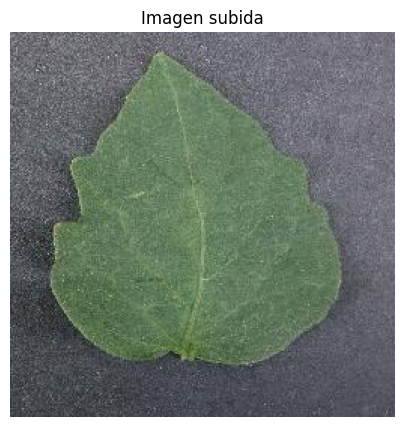


 TOP1: Tomato___healthy | conf=1.000

 Top-5:
 - Tomato___healthy: 1.000
 - Tomato___Late_blight: 0.000
 - Tomato___Target_Spot: 0.000
 - Tomato___Septoria_leaf_spot: 0.000
 - Tomato___Spider_mites Two-spotted_spider_mite: 0.000


In [9]:
# ============================================
# 9) Subir imagen + probar modelo entrenado (YOLOv8-cls)
# ============================================

from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1) Subir imagen
from google.colab import files
uploaded = files.upload()

if not uploaded:
    raise RuntimeError(" No se subió ninguna imagen.")

img_path = Path(next(iter(uploaded.keys())))
print(f" Imagen subida: {img_path} ({img_path.stat().st_size/1024:.1f} KB)")

# 2) Encontrar modelo (preferimos el empaquetado)
artifact_best = Path("/content/artifacts_yolo_cls/best.pt")
runs_dir = Path("runs/classify")

if artifact_best.exists():
    best_pt = artifact_best
else:
    # fallback: buscar último entrenamiento
    exp_dirs = [d for d in runs_dir.iterdir() if d.is_dir() and d.name.startswith("train")]
    if not exp_dirs:
        raise FileNotFoundError(" No se encontró best.pt ni artifacts ni runs/classify. Entrena primero.")
    latest_exp = max(exp_dirs, key=lambda p: p.stat().st_mtime)
    best_pt = latest_exp / "weights" / "best.pt"
    if not best_pt.exists():
        raise FileNotFoundError(f" No existe {best_pt}. Revisa el entrenamiento.")

print(f" Usando modelo: {best_pt}")

# 3) Cargar modelo y predecir
model = YOLO(str(best_pt))
res = model.predict(str(img_path), imgsz=224, verbose=False)[0]

# 4) Mostrar imagen
img = plt.imread(str(img_path))
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Imagen subida")
plt.show()

# 5) Mostrar predicciones
if hasattr(res, "probs") and res.probs is not None:
    top1_idx = int(res.probs.top1)
    top1_conf = float(res.probs.top1conf)
    top1_name = res.names.get(top1_idx, str(top1_idx))

    print(f"\n TOP1: {top1_name} | conf={top1_conf:.3f}")

    # Top-5
    if hasattr(res.probs, "top5"):
        print("\n Top-5:")
        for idx in res.probs.top5:
            idx = int(idx)
            name = res.names.get(idx, str(idx))
            conf = float(res.probs.data[idx])
            print(f" - {name}: {conf:.3f}")
else:
    print(" No se encontraron probabilidades en el resultado. (posible diferencia de versión/backend)")
    print(res)
